# Flood Prediction Model 1 - Hourly Discharge at Caboolture River

The Objective of this notebook is to create a flood prediction model for the Caboolture River at Upper Caboolture. We will use hourly rainfall data and an hourly discharge as the target time series and a single hourly rainfall time series as input variable. This model will be used for comparision with [RORB](https://www.monash.edu/engineering/departments/civil/research/themes/water/rorb)’s predictions.

## Benchmark Model

[RORB](https://www.monash.edu/engineering/departments/civil/research/themes/water/rorb) model is generally employed for calculating design flood discharges. It uses many assumptions and is manually calibrated to one flooding event. This will be used as benchmark model for comparison purpose.

## Data Set
The hydrological data available at [Queensland Water Monitoring Information Portal](https://water-monitoring.information.qld.gov.au/) will be used. Hourly as well as daily water flow data is available at various stations. Rainfall data is available in some of the stations. For the Caboolture River, only single discharge and rainfal station is available. 



### Work Workflow

* Preprocessing and exploring the data
* Creating training and test sets of time series
* Formatting data as JSON files and uploading to S3
* Instantiating and training a DeepAR estimator
* Deploying a model and creating a predictor
* Comparing the Predictor with RORB's performance

# Preprocessing and exploring the data

The raw data for Caboolture River is available at raw_data/Caboolture folder. 

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [167]:
def unzip_ts_data(data_dir):
    '''
    Unzip all the zip files in the given data directory
    Then, it will return a list of path to all the extracted csv files.

    data_dir: path to directory containing ts zip files
    
    '''

    # Zip data files in Caboolture folder
    zip_files = os.listdir(data_dir)

    # List to store path to the csv files
    csv_paths = [] 

    for zip_file in zip_files:
        if '.zip' in zip_file:
            # Directory name to extract contents of zip file
            zip_dir = data_dir + '/' + zip_file.split('.')[0]

            # Delete directory if it exists
            if os.path.exists(zip_dir):
                !rm -r {zip_dir}

            # Create dir and unzip
            ! mkdir {zip_dir}
            ! unzip {data_dir}/{zip_file} -d {zip_dir}
            print('unzipped {}!'.format(zip_file))

            # Save path to csv
            for file_name in os.listdir(zip_dir):
                if '.csv' in file_name:
                    csv_paths.append('{}/{}'.format(zip_dir,file_name))
                    
    return csv_paths

In [193]:
def read_ts_data(file_path, skiprows = 3, skipfooter = 2, time_col = "Date and time", value_cols = ["Mean"], prefix = ""):
    '''
    Read the time series csv data and return a pandas data frame with two variables Time and Value
    file_path: csv file path
    
    skiprows: number of top rows to skip
    skipfooter: number of bottom rows to skip
    time_col: name of the timestamp column
    value_cols: name of the target value column
    '''
    
    # Read csv and remove bottom two rows
    ts_data_raw = pd.read_csv(file_path, skiprows = skiprows, skipfooter = skipfooter, 
                              parse_dates={'DateTime' : [time_col]}, infer_datetime_format=True,
                              index_col='DateTime', engine = 'python')
    
    # Select appropriate columns and rename them
    ts_data = ts_data_raw[value_cols]
    ts_data.rename( dict( zip( value_cols, [prefix+x for x in value_cols]) ), axis = 1, inplace=True )
    
    return ts_data
    
    


In [244]:
# Read target (flow) and feature (rain) data

target_name = '142001A_20191103_flow' # folder name containing target time series

# Unzip the data and get list of csv paths
cabooltre_csv_paths = unzip_ts_data('./raw_data/Caboolture')
maroochy_csv_paths = unzip_ts_data('./raw_data/Maroochy')
brisbane_csv_paths = unzip_ts_data('./raw_data/Brisbane')

# Select the target csv
target_csv_paths = []
other_csv_paths = []
for csv_path in cabooltre_csv_paths:
    if target_name in csv_path:
        target_csv_paths.append(csv_path)
    else:
        other_csv_paths.append(csv_path)
        


Archive:  ./raw_data/Caboolture/142001A_20191103_rain.zip
  inflating: ./raw_data/Caboolture/142001A_20191103_rain/142001A.csv  
  inflating: ./raw_data/Caboolture/142001A_20191103_rain/Copyright.pdf  
  inflating: ./raw_data/Caboolture/142001A_20191103_rain/Disclaimer.pdf  
  inflating: ./raw_data/Caboolture/142001A_20191103_rain/webglossary.pdf  
unzipped 142001A_20191103_rain.zip!
Archive:  ./raw_data/Caboolture/142001A_20191103_flow.zip
  inflating: ./raw_data/Caboolture/142001A_20191103_flow/142001A.csv  
  inflating: ./raw_data/Caboolture/142001A_20191103_flow/Copyright.pdf  
  inflating: ./raw_data/Caboolture/142001A_20191103_flow/Disclaimer.pdf  
  inflating: ./raw_data/Caboolture/142001A_20191103_flow/webglossary.pdf  
unzipped 142001A_20191103_flow.zip!
Archive:  ./raw_data/Maroochy/141004B_20191110_rain.zip
  inflating: ./raw_data/Maroochy/141004B_20191110_rain/141004B.csv  
  inflating: ./raw_data/Maroochy/141004B_20191110_rain/Copyright.pdf  
  inflating: ./raw_data/Marooc

In [245]:
# Read the extracted csv data

target_ts_data = read_ts_data(target_csv_paths[0], value_cols = ["Mean"], prefix = "CabFlow")

rain_ts_data = read_ts_data(other_csv_paths[0], value_cols = ["Total"], prefix = "CabRain")

rain_maroochy_ts_data = read_ts_data(maroochy_csv_paths[0], value_cols = ["Total"], prefix = "MarRain")
rain_brisbane_ts_data = read_ts_data(brisbane_csv_paths[0], value_cols = ["Total"], prefix = "BrisRain")


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [247]:
main_ts_data = target_ts_data.join(rain_ts_data)


## Missing Values

First we remove the missing values from the both ends of time. After doing so, we find that there are no missing values for the flow data while there are some missing data for the rainfall data. We replace the missing rainfall data with the rainfall from the nearest station in Maroochy basin.

In [248]:
def first_last_non_null(all_ts_data):
    """
    Returns the index for first and last non-null rows on data
    """
    selec_non_null = np.apply_along_axis(np.sum, 1, ~pd.isnull(all_ts_data).values) >= 2
    # Find the first and last non-null index for all data
    first_index = all_ts_data.index[selec_non_null][0]
    last_index = all_ts_data.index[selec_non_null][-1]

    return first_index, last_index

# Select for this period

first_index, last_index = first_last_non_null(main_ts_data)

selec_all_ts_data = main_ts_data.iloc[(main_ts_data.index >= first_index) & (main_ts_data.index <= last_index),]

selec_all_ts_data.describe()

,CabFlowMean,CabRainTotal
count,248640.000000,244332.000000
mean,0.939243,0.128908
std,8.070325,1.135370
min,0.000000,0.000000
25%,0.017500,0.000000
50%,0.074000,0.000000
75%,0.252000,0.000000
max,567.881600,87.000000


In [266]:
# Replace the missing rainfall with Maroochy rain

selec2_all_ts_data = selec_all_ts_data.join(rain_maroochy_ts_data)

selec2_all_ts_data.iloc[pd.isnull(selec2_all_ts_data.iloc[:,1]).values,1] = selec2_all_ts_data.iloc[pd.isnull(selec2_all_ts_data.iloc[:,1]).values,2]

selec2_all_ts_data.drop("MarRainTotal", 1, inplace = True)

In [267]:
selec2_all_ts_data.describe()

,CabFlowMean,CabRainTotal
count,248640.000000,248640.000000
mean,0.939243,0.129345
std,8.070325,1.138789
min,0.000000,0.000000
25%,0.017500,0.000000
50%,0.074000,0.000000
75%,0.252000,0.000000
max,567.881600,87.000000


<Figure size 1440x432 with 0 Axes>

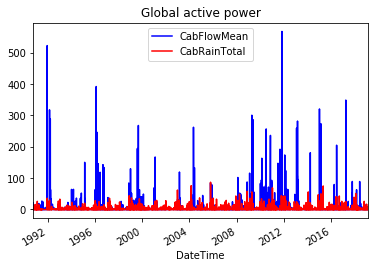

In [269]:
# Plot filter

# display the data 
plt.figure(figsize=(20,6))
# all data points
selec2_all_ts_data.plot(title='Global active power', color=['blue','red']) 
plt.show()

# Spliting to Training and Test Series
Now we split the data into training and test series. Data up to 2016 will be used for training and then the rest for testing.

In [277]:
train_all_ts_data = selec2_all_ts_data.iloc[selec2_all_ts_data.index < pd.Timestamp('2016-01-01 00:00:00'),:]
test_all_ts_data = selec2_all_ts_data.iloc[selec2_all_ts_data.index >= pd.Timestamp('2016-01-01 00:00:00'),:]

# Convert to JSON


In [279]:
test_all_ts_data.head()

,CabFlowMean,CabRainTotal
DateTime,,
2016-01-01 00:00:00,0.0285,0.0
2016-01-01 01:00:00,0.0280,0.0
2016-01-01 02:00:00,0.0262,0.0
2016-01-01 03:00:00,0.0255,0.0
2016-01-01 04:00:00,0.0260,0.0


In [311]:
target_col = "CabFlowMean"
test_all_ts_data[[target_col,target_col]].values.transpose()

array([[0.0285, 0.028 , 0.0262, ..., 0.009 , 0.009 , 0.009 ],
       [0.0285, 0.028 , 0.0262, ..., 0.009 , 0.009 , 0.009 ]])

In [301]:
test_all_ts_data.columns.values

array(['CabFlowMean', 'CabRainTotal'], dtype=object)

In [312]:
def series_to_json(ts, target_col):
    '''Returns a dictionary of values in DeepAR, JSON format.
    
       ts: A single time series.
       target_col: col name for target series (other series will be used as dynamic feature)
       
       return: A dictionary of values with "start", "target" and dynamic keys.
       '''
    # your code here
    remain_col = []
    for col in ts.columns.values:
        if col!= target_col:
            remain_col.append(col)
    
    json_obj = {'start' : ts.index[0].strftime('%Y-%m-%d %H:%M:%S'), 
                'target' : ts[target_col].values.tolist(),
                'dynamic_feat' : ts[remain_col].values.transpose().tolist()}
    return json_obj


In [313]:
target_col = "CabFlowMean"
train_json = series_to_json(train_all_ts_data, target_col)

# Save Data Locally

In [315]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, target_col, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json(ts, target_col)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [316]:
# save this data to a local directory
data_dir = 'json_model1_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
# directories to save train/test data
train_path = os.path.join(data_dir, 'train.json')
test_path = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(train_all_ts_data, target_col, train_path)        
write_json_dataset(train_all_ts_data, target_col, test_path)